In [1]:
import pycisTopic
import glob
import os
import pybiomart as pbm
import pandas as pd
import pickle
from pycisTopic.qc import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import multiprocess as mp  # for kde multithreading calculation
from multiprocess import Pool

%matplotlib inline
%load_ext lab_black

# Download annotation

In [2]:
!pwd

/lustre1/project/stg_00090/scatac_benchmark/fixedcells_3_cistopic_consensus


In [3]:
wdir = "/lustre1/project/stg_00090/scatac_benchmark/fixedcells_3_cistopic_consensus"
os.chdir(wdir)

In [5]:
genome = "hg38"

pbm_genome_name_dict = {
    "hg38": "hsapiens_gene_ensembl",
    "hg37": "hsapiens_gene_ensembl",
    "mm10": "mmusculus_gene_ensembl",
    "dm6": "dmelanogaster_gene_ensembl",
}

pbm_host_dict = {
    "hg38": "http://www.ensembl.org",
    "hg37": "http://grch37.ensembl.org/",
    "mm10": "http://nov2020.archive.ensembl.org/",
    "dm6": "http://www.ensembl.org",
}

if os.path.exists(f"annotation.tsv"):
    print(f"Loading cached genome annotation...")
    annotation = pd.read_csv("annotation.tsv", sep="\t", header=0, index_col=0)
else:
    dataset = pbm.Dataset(name=pbm_genome_name_dict[genome], host=pbm_host_dict[genome])

    annotation = dataset.query(
        attributes=[
            "chromosome_name",
            "transcription_start_site",
            "strand",
            "external_gene_name",
            "transcript_biotype",
        ]
    )
    filter = annotation["Chromosome/scaffold name"].str.contains("CHR|GL|JH|MT")
    annotation = annotation[~filter]
    annotation["Chromosome/scaffold name"] = annotation[
        "Chromosome/scaffold name"
    ].str.replace(r"(\b\S)", r"chr\1")
    annotation.columns = ["Chromosome", "Start", "Strand", "Gene", "Transcript_type"]
    annottation = annotation[annotation.Transcript_type == "protein_coding"]
    annotation.to_csv("annotation.tsv", sep="\t")

Loading cached genome annotation...


In [6]:
annotation

,Chromosome,Start,Strand,Gene,Transcript_type
57,chrKI270711chr.chr1,24650,-1,NaN,protein_coding
58,chrKI270711chr.chr1,29626,-1,NaN,protein_coding
628,chrKI270734chr.chr1,161852,-1,NaN,protein_coding
629,chrKI270734chr.chr1,161750,-1,NaN,protein_coding
713,chrKI270734chr.chr1,131494,1,NaN,protein_coding
...,...,...,...,...,...
242597,chr1,154257071,1,UBAP2L,protein_coding
242604,chr1,154272589,1,HAX1,protein_coding
242605,chr1,154272609,1,HAX1,protein_coding
242607,chr1,154272629,1,HAX1,protein_coding


In [4]:
fragments_list = sorted(glob.glob("../1_data_repository/fixedcells_fragments/*.tsv.gz"))
fragments_dict = {}
for fragments_file in fragments_list:
    sample = fragments_file.split("/")[-1].split(".fragments.tsv.gz")[0]
    fragments_dict[sample] = fragments_file
fragments_dict

{'BIO_ddseq_1.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BIO_ddseq_1.FIXEDCELLS.fragments.tsv.gz',
 'BIO_ddseq_2.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BIO_ddseq_2.FIXEDCELLS.fragments.tsv.gz',
 'BIO_ddseq_3.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BIO_ddseq_3.FIXEDCELLS.fragments.tsv.gz',
 'BIO_ddseq_4.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BIO_ddseq_4.FIXEDCELLS.fragments.tsv.gz',
 'BRO_mtscatac_1.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BRO_mtscatac_1.FIXEDCELLS.fragments.tsv.gz',
 'BRO_mtscatac_2.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BRO_mtscatac_2.FIXEDCELLS.fragments.tsv.gz',
 'CNA_10xmultiome_1.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/CNA_10xmultiome_1.FIXEDCELLS.fragments.tsv.gz',
 'CNA_10xmultiome_2.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/CNA_10xmultiome_2.FIXEDCELLS.fragments.tsv.gz',
 'CNA_10xv11_1.FIXEDCELLS': '../1_data_repository/fixedcells_fragmen

In [5]:
regions = "../0_resources/regions/hg38-blacklist.v2.bed"

In [6]:
regions_dict = {x: regions for x in fragments_dict.keys()}
regions_dict

{'BIO_ddseq_1.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'BIO_ddseq_2.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'BIO_ddseq_3.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'BIO_ddseq_4.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'BRO_mtscatac_1.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'BRO_mtscatac_2.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'CNA_10xmultiome_1.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'CNA_10xmultiome_2.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'CNA_10xv11_1.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'CNA_10xv11_2.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'CNA_10xv11_3.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'CNA_10xv11_4.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 'CNA_10xv11_5.FIXEDCELLS': '../0_resources/regions/hg38-blacklist.v2.bed',
 '

Now, make a sub dictionary of all samples within the fragments dict that have not been run yet (good for resuming a stopped cistopic run):

In [10]:
cistopic_qc_out = os.path.join(wdir, "cistopic_qc_out_BLACKLIST")
if not os.path.exists(cistopic_qc_out):
    os.makedirs(cistopic_qc_out)

In [12]:
fragments_sub_dict = {}
regions_sub_dict = {}
for sample in regions_paths_dict.keys():
    metadata_file = os.path.join(
        cistopic_qc_out, sample + "__metadata_bc_blacklist.pkl"
    )
    print(f"Checking if {metadata_file} exist...")
    if os.path.exists(metadata_file):
        print("\tMetadata exists! Skipping...")
    else:
        fragments_sub_dict[sample] = fragments_dict[sample]
        print("\tMetadata does not exist, adding to subdict to generate")

Checking if /lustre1/project/stg_00090/scatac_benchmark/fixedcells_3_cistopic_consensus/cistopic_qc_out_BLACKLIST/BIO_ddseq_1.FIXEDCELLS__metadata_bc_blacklist.pkl exist...
	Metadata does not exist, adding to subdict to generate
Checking if /lustre1/project/stg_00090/scatac_benchmark/fixedcells_3_cistopic_consensus/cistopic_qc_out_BLACKLIST/BIO_ddseq_2.FIXEDCELLS__metadata_bc_blacklist.pkl exist...
	Metadata does not exist, adding to subdict to generate
Checking if /lustre1/project/stg_00090/scatac_benchmark/fixedcells_3_cistopic_consensus/cistopic_qc_out_BLACKLIST/BIO_ddseq_3.FIXEDCELLS__metadata_bc_blacklist.pkl exist...
	Metadata does not exist, adding to subdict to generate
Checking if /lustre1/project/stg_00090/scatac_benchmark/fixedcells_3_cistopic_consensus/cistopic_qc_out_BLACKLIST/BIO_ddseq_4.FIXEDCELLS__metadata_bc_blacklist.pkl exist...
	Metadata does not exist, adding to subdict to generate
Checking if /lustre1/project/stg_00090/scatac_benchmark/fixedcells_3_cistopic_consen

In [12]:
ray.shutdown()

In [17]:
n_cores = 16
if fragments_sub_dict != {}:
    samples_sub = list(fragments_sub_dict.keys())
    blocks = [samples_sub[i : i + n_cores] for i in range(0, len(samples_sub), n_cores)]
    for samples_torun_in_block in blocks:
        fragments_sub_dict_block = {
            key: fragments_sub_dict[key] for key in samples_torun_in_block
        }

        metadata_bc_dict, profile_data_dict = compute_qc_stats(
            fragments_dict=fragments_sub_dict_block,
            tss_annotation=annotation,
            stats=[
                "barcode_rank_plot",
                "duplicate_rate",
                "insert_size_distribution",
                "profile_tss",
                "frip",
            ],
            label_list=None,
            path_to_regions=regions_dict,
            n_cpu=n_cores,
            valid_bc=None,
            n_frag=10,
            n_bc=None,
            tss_flank_window=2000,
            tss_window=50,
            tss_minimum_signal_window=100,
            tss_rolling_window=10,
            # min_norm=0.2,
            remove_duplicates=True,
        )

        ray.shutdown()
        print(f"Dumping files in {cistopic_qc_out}...")
        for sample in sorted(metadata_bc_dict.keys()):
            metadata_bc_dict[sample]["sample_id"] = sample
            metadata_bc_dict[sample].index = [
                x + "___" + sample for x in list(metadata_bc_dict[sample].index)
            ]
            with open(
                os.path.join(cistopic_qc_out, f"{sample}__metadata_bc_blacklist.pkl"),
                "wb",
            ) as f:
                pickle.dump(metadata_bc_dict[sample], f, protocol=4)

            with open(
                os.path.join(cistopic_qc_out, f"{sample}__profile_data_blacklist.pkl"),
                "wb",
            ) as f:
                pickle.dump(profile_data_dict[sample], f, protocol=4)
else:
    print("All samples already processed.")

2022-12-08 11:15:46,134	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(compute_qc_stats_ray pid=12003) 2022-12-08 11:15:49,658 cisTopic     INFO     Reading BRO_mtscatac_1.FIXEDCELLS
(compute_qc_stats_ray pid=12013) 2022-12-08 11:15:49,609 cisTopic     INFO     Reading CNA_10xmultiome_1.FIXEDCELLS
(compute_qc_stats_ray pid=12014) 2022-12-08 11:15:49,609 cisTopic     INFO     Reading BIO_ddseq_4.FIXEDCELLS
(compute_qc_stats_ray pid=12007) 2022-12-08 11:15:49,625 cisTopic     INFO     Reading BRO_mtscatac_2.FIXEDCELLS
(compute_qc_stats_ray pid=12008) 2022-12-08 11:15:49,667 cisTopic     INFO     Reading BIO_ddseq_1.FIXEDCELLS
(compute_qc_stats_ray pid=12015) 2022-12-08 11:15:49,658 cisTopic     INFO     Reading BIO_ddseq_3.FIXEDCELLS
(compute_qc_stats_ray pid=12002) 2022-12-08 11:15:49,675 cisTopic     INFO     Reading BIO_ddseq_2.FIXEDCELLS
(compute_qc_stats_ray pid=12006) 2022-12-08 11:15:49,686 cisTopic     INFO     Reading CNA_10xv11_1.FIXEDCELLS
(compute_qc_stats_ray pid=12011) 2022-12-08 11:15:49,684 cisTopic     INFO     Reading CNA_10xmultiome_2.FI

2022-12-08 11:26:14,705	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(compute_qc_stats_ray pid=15511) 2022-12-08 11:26:18,317 cisTopic     INFO     Reading CNA_hydrop_2.FIXEDCELLS
(compute_qc_stats_ray pid=15512) 2022-12-08 11:26:18,340 cisTopic     INFO     Reading EPF_hydrop_3.FIXEDCELLS
(compute_qc_stats_ray pid=15510) 2022-12-08 11:26:18,339 cisTopic     INFO     Reading EPF_hydrop_1.FIXEDCELLS
(compute_qc_stats_ray pid=15505) 2022-12-08 11:26:18,347 cisTopic     INFO     Reading CNA_mtscatac_2.FIXEDCELLS
(compute_qc_stats_ray pid=15508) 2022-12-08 11:26:18,360 cisTopic     INFO     Reading EPF_hydrop_4.FIXEDCELLS
(compute_qc_stats_ray pid=15499) 2022-12-08 11:26:18,403 cisTopic     INFO     Reading MDC_mtscatac_2.FIXEDCELLS
(compute_qc_stats_ray pid=15500) 2022-12-08 11:26:18,429 cisTopic     INFO     Reading EPF_hydrop_2.FIXEDCELLS
(compute_qc_stats_ray pid=15503) 2022-12-08 11:26:18,390 cisTopic     INFO     Reading HAR_ddseq_2.FIXEDCELLS
(compute_qc_stats_ray pid=15513) 2022-12-08 11:26:18,407 cisTopic     INFO     Reading CNA_hydrop_3.FIXEDCELL

2022-12-08 11:37:20,901	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(compute_qc_stats_ray pid=19391) 2022-12-08 11:37:24,390 cisTopic     INFO     Reading STA_10xv11_2.FIXEDCELLS
(compute_qc_stats_ray pid=19394) 2022-12-08 11:37:24,462 cisTopic     INFO     Reading STA_10xv11_1.FIXEDCELLS
(compute_qc_stats_ray pid=19401) 2022-12-08 11:37:24,563 cisTopic     INFO     Reading TXG_10xv11_1.FIXEDCELLS
(compute_qc_stats_ray pid=19396) 2022-12-08 11:37:24,563 cisTopic     INFO     Reading UCS_ddseq_1.FIXEDCELLS
(compute_qc_stats_ray pid=19399) 2022-12-08 11:37:24,587 cisTopic     INFO     Reading TXG_10xv2_1.FIXEDCELLS
(compute_qc_stats_ray pid=19400) 2022-12-08 11:37:24,564 cisTopic     INFO     Reading UCS_ddseq_2.FIXEDCELLS
(compute_qc_stats_ray pid=19403) 2022-12-08 11:37:24,641 cisTopic     INFO     Reading VIB_10xv2_1.FIXEDCELLS
(compute_qc_stats_ray pid=19389) 2022-12-08 11:37:24,646 cisTopic     INFO     Reading TXG_10xv2_2.FIXEDCELLS
(compute_qc_stats_ray pid=19392) 2022-12-08 11:37:24,654 cisTopic     INFO     Reading VIB_10xmultiome_1.FIXEDCELLS
(

2022-12-08 11:52:58,504	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(compute_qc_stats_ray pid=23356) 2022-12-08 11:53:01,671 cisTopic     INFO     Reading VIB_hydrop_2.FIXEDCELLS
(compute_qc_stats_ray pid=23357) 2022-12-08 11:53:01,678 cisTopic     INFO     Reading VIB_hydrop_21.FIXEDCELLS
(compute_qc_stats_ray pid=23355) 2022-12-08 11:53:01,706 cisTopic     INFO     Reading VIB_hydrop_22.FIXEDCELLS
(compute_qc_stats_ray pid=23355) 2022-12-08 11:53:22,621 cisTopic     INFO     Computing barcode rank plot for VIB_hydrop_22.FIXEDCELLS
(compute_qc_stats_ray pid=23355) 2022-12-08 11:53:22,622 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=23355) 2022-12-08 11:53:23,220 cisTopic     INFO     Marking barcodes with more than 10
(compute_qc_stats_ray pid=23355) 2022-12-08 11:53:23,235 cisTopic     INFO     Returning plot data
(compute_qc_stats_ray pid=23355) 2022-12-08 11:53:23,243 cisTopic     INFO     Returning valid barcodes
(compute_qc_stats_ray pid=23355) 2022-12-08 11:53:23,762 cisTopic     INFO     Computing duplicate rate plot for V

In [7]:
metadata_path_dict = {
    x.split("/")[-1].split("__")[0]: x
    for x in sorted(
        glob.glob("cistopic_qc_out_BLACKLIST/*FIXEDCELLS__metadata_bc_blacklist.pkl")
    )
}

In [8]:
cell_data_path_dict = {
    x.split("/")[-1].split("__")[0]: x
    for x in sorted(glob.glob("cistopic_objects/*consensus.cell_data.tsv"))
}

In [32]:
metadata_df_merged = pd.DataFrame()
for sample, path in metadata_path_dict.items():
    print(sample)
    with open(path, "rb") as f:
        metadata_df = pickle.load(f)

    df_bcs = pd.read_csv(cell_data_path_dict[sample], index_col=0, sep="\t")
    bcs = df_bcs.index
    if "VIB_hydrop" in sample:
        bcs = [
            x.split("___")[0]
            + "-"
            + x.split("_")[-1].split(".")[0][-1]
            + "___VIB_hydrop_"
            + x.split("_")[-1].split(".")[0][0]
            + ".FIXEDCELLS"
            for x in bcs
        ]
    # bcs = [x.replace("FULL", "FIXEDCELLS") for x in bcs]
    metadata_df = metadata_df.loc[bcs]
    metadata_df_merged = pd.concat([metadata_df_merged, metadata_df])

BIO_ddseq_1.FIXEDCELLS
BIO_ddseq_2.FIXEDCELLS
BIO_ddseq_3.FIXEDCELLS
BIO_ddseq_4.FIXEDCELLS
BRO_mtscatac_1.FIXEDCELLS
BRO_mtscatac_2.FIXEDCELLS
CNA_10xmultiome_1.FIXEDCELLS
CNA_10xmultiome_2.FIXEDCELLS
CNA_10xv11_1.FIXEDCELLS
CNA_10xv11_2.FIXEDCELLS
CNA_10xv11_3.FIXEDCELLS
CNA_10xv11_4.FIXEDCELLS
CNA_10xv11_5.FIXEDCELLS
CNA_10xv2_1.FIXEDCELLS
CNA_10xv2_2.FIXEDCELLS
CNA_hydrop_1.FIXEDCELLS
CNA_hydrop_2.FIXEDCELLS
CNA_hydrop_3.FIXEDCELLS
CNA_mtscatac_1.FIXEDCELLS
CNA_mtscatac_2.FIXEDCELLS
EPF_hydrop_1.FIXEDCELLS
EPF_hydrop_2.FIXEDCELLS
EPF_hydrop_3.FIXEDCELLS
EPF_hydrop_4.FIXEDCELLS
HAR_ddseq_1.FIXEDCELLS
HAR_ddseq_2.FIXEDCELLS
MDC_mtscatac_1.FIXEDCELLS
MDC_mtscatac_2.FIXEDCELLS
OHS_s3atac_1.FIXEDCELLS
OHS_s3atac_2.FIXEDCELLS
SAN_10xmultiome_1.FIXEDCELLS
SAN_10xmultiome_2.FIXEDCELLS
STA_10xv11_1.FIXEDCELLS
STA_10xv11_2.FIXEDCELLS
TXG_10xv11_1.FIXEDCELLS
TXG_10xv2_1.FIXEDCELLS
TXG_10xv2_2.FIXEDCELLS
UCS_ddseq_1.FIXEDCELLS
UCS_ddseq_2.FIXEDCELLS
VIB_10xmultiome_1.FIXEDCELLS
VIB_10xmultiome

In [33]:
metadata_df_merged

,Log_total_nr_frag,Log_unique_nr_frag,Total_nr_frag,Unique_nr_frag,Dupl_nr_frag,Dupl_rate,Total_nr_frag_in_regions,Unique_nr_frag_in_regions,FRIP,TSS_enrichment,sample_id
CAGGCGGATGAATAAAGTGCG_CGCGGCGACCTACCGCAGTGT___BIO_ddseq_1.FIXEDCELLS,4.495669,3.925415,31309,8422,22887,0.731004,221,65,0.007718,38.887733,BIO_ddseq_1.FIXEDCELLS
ACACGCGATATAACATTCGTT_TTCCTCTTCGTTCTGCTAATT___BIO_ddseq_1.FIXEDCELLS,4.434553,3.819215,27199,6595,20604,0.757528,185,52,0.007885,40.580825,BIO_ddseq_1.FIXEDCELLS
AACGGTGGAGAGGTTAGTGTT_TTGTAAGCGTTTGATGAGGAG___BIO_ddseq_1.FIXEDCELLS,4.727330,4.125741,53374,13358,40016,0.749728,381,89,0.006663,29.227156,BIO_ddseq_1.FIXEDCELLS
ATAGTTGTGAGATTGAATCAA___BIO_ddseq_1.FIXEDCELLS,4.381927,3.901295,24095,7967,16128,0.669350,133,38,0.004770,29.081667,BIO_ddseq_1.FIXEDCELLS
TACGCATTCTGAACGAGCGTG___BIO_ddseq_1.FIXEDCELLS,4.313952,3.876102,20604,7518,13086,0.635119,156,48,0.006385,33.464056,BIO_ddseq_1.FIXEDCELLS
...,...,...,...,...,...,...,...,...,...,...,...
GACGAGGTAAGATGGCCAAC-2___VIB_hydrop_2.FIXEDCELLS,3.219846,3.011147,1659,1026,633,0.381555,3,2,0.001949,35.755000,VIB_hydrop_2.FIXEDCELLS
AGGTTGCATTATCCGAGTAT-2___VIB_hydrop_2.FIXEDCELLS,3.386321,3.064083,2434,1159,1275,0.523829,6,2,0.001726,23.245000,VIB_hydrop_2.FIXEDCELLS
TCAAGAGGCGAGGACGTTCG-2___VIB_hydrop_2.FIXEDCELLS,3.632457,3.265996,4290,1845,2445,0.569930,21,6,0.003252,43.741158,VIB_hydrop_2.FIXEDCELLS
GGAGTATTCTCAAGACGTCT-2___VIB_hydrop_2.FIXEDCELLS,3.788239,3.291369,6141,1956,4185,0.681485,39,13,0.006646,41.785295,VIB_hydrop_2.FIXEDCELLS


In [52]:
all_order = [
    "VIB_10xv1_1.FIXEDCELLS",
    "VIB_10xv1_2.FIXEDCELLS",
    "CNA_10xv11_1.FIXEDCELLS",
    "CNA_10xv11_2.FIXEDCELLS",
    "CNA_10xv11_3.FIXEDCELLS",
    "CNA_10xv11c_1.FIXEDCELLS",
    "CNA_10xv11c_2.FIXEDCELLS",
    "STA_10xv11_1.FIXEDCELLS",
    "STA_10xv11_2.FIXEDCELLS",
    "TXG_10xv11_1.FIXEDCELLS",
    "CNA_10xv2_1.FIXEDCELLS",
    "CNA_10xv2_2.FIXEDCELLS",
    "TXG_10xv2_1.FIXEDCELLS",
    "TXG_10xv2_2.FIXEDCELLS",
    "VIB_10xv2_1.FIXEDCELLS",
    "VIB_10xv2_2.FIXEDCELLS",
    "CNA_10xmultiome_1.FIXEDCELLS",
    "CNA_10xmultiome_2.FIXEDCELLS",
    "SAN_10xmultiome_1.FIXEDCELLS",
    "SAN_10xmultiome_2.FIXEDCELLS",
    "VIB_10xmultiome_1.FIXEDCELLS",
    "VIB_10xmultiome_2.FIXEDCELLS",
    "BRO_mtscatacfacs_1.FIXEDCELLS",
    "BRO_mtscatacfacs_2.FIXEDCELLS",
    "CNA_mtscatac_1.FIXEDCELLS",
    "CNA_mtscatac_2.FIXEDCELLS",
    "MDC_mtscatac_1.FIXEDCELLS",
    "MDC_mtscatac_2.FIXEDCELLS",
    "BIO_ddseq_1.FIXEDCELLS",
    "BIO_ddseq_2.FIXEDCELLS",
    "BIO_ddseq_3.FIXEDCELLS",
    "BIO_ddseq_4.FIXEDCELLS",
    "HAR_ddseq_1.FIXEDCELLS",
    "HAR_ddseq_2.FIXEDCELLS",
    "UCS_ddseq_1.FIXEDCELLS",
    "UCS_ddseq_2.FIXEDCELLS",
    "OHS_s3atac_1.FIXEDCELLS",
    "OHS_s3atac_2.FIXEDCELLS",
    "CNA_hydrop_1.FIXEDCELLS",
    "CNA_hydrop_2.FIXEDCELLS",
    "CNA_hydrop_3.FIXEDCELLS",
    "EPF_hydrop_1.FIXEDCELLS",
    "EPF_hydrop_2.FIXEDCELLS",
    "EPF_hydrop_3.FIXEDCELLS",
    "EPF_hydrop_4.FIXEDCELLS",
    "VIB_hydrop_1.FIXEDCELLS",
    "VIB_hydrop_2.FIXEDCELLS",
]

sample_id_ultrashort_alias_dict = {
    "BIO_ddseq_1.FIXEDCELLS": "ddS Bi1",
    "BIO_ddseq_2.FIXEDCELLS": "ddS Bi2",
    "BIO_ddseq_3.FIXEDCELLS": "ddS Bi3",
    "BIO_ddseq_4.FIXEDCELLS": "ddS Bi4",
    "BRO_mtscatacfacs_1.FIXEDCELLS": "mt* Br1",
    "BRO_mtscatacfacs_2.FIXEDCELLS": "mt* Br2",
    "CNA_10xmultiome_1.FIXEDCELLS": "MO C1",
    "CNA_10xmultiome_2.FIXEDCELLS": "MO C2",
    "CNA_10xv11_1.FIXEDCELLS": "v1.1 C1",
    "CNA_10xv11_2.FIXEDCELLS": "v1.1 C2",
    "CNA_10xv11_3.FIXEDCELLS": "v1.1 C3",
    "CNA_10xv11c_1.FIXEDCELLS": "v1.1c C1",
    "CNA_10xv11c_2.FIXEDCELLS": "v1.1c C2",
    "CNA_10xv2_1.FIXEDCELLS": "v2 C1",
    "CNA_10xv2_2.FIXEDCELLS": "v2 C2",
    "CNA_hydrop_1.FIXEDCELLS": "Hy C1",
    "CNA_hydrop_2.FIXEDCELLS": "Hy C2",
    "CNA_hydrop_3.FIXEDCELLS": "Hy C3",
    "CNA_mtscatac_1.FIXEDCELLS": "mt C1",
    "CNA_mtscatac_2.FIXEDCELLS": "mt C2",
    "EPF_hydrop_1.FIXEDCELLS": "Hy E1",
    "EPF_hydrop_2.FIXEDCELLS": "Hy E2",
    "EPF_hydrop_3.FIXEDCELLS": "Hy E3",
    "EPF_hydrop_4.FIXEDCELLS": "Hy E4",
    "HAR_ddseq_1.FIXEDCELLS": "ddS H1",
    "HAR_ddseq_2.FIXEDCELLS": "ddS H2",
    "MDC_mtscatac_1.FIXEDCELLS": "mt M1",
    "MDC_mtscatac_2.FIXEDCELLS": "mt M2",
    "OHS_s3atac_1.FIXEDCELLS": "s3 O1",
    "OHS_s3atac_2.FIXEDCELLS": "s3 O2",
    "SAN_10xmultiome_1.FIXEDCELLS": "MO Sa1",
    "SAN_10xmultiome_2.FIXEDCELLS": "MO Sa2",
    "STA_10xv11_1.FIXEDCELLS": "v1.1 St1",
    "STA_10xv11_2.FIXEDCELLS": "v1.1 St2",
    "TXG_10xv11_1.FIXEDCELLS": "v1.1 T1",
    "TXG_10xv2_1.FIXEDCELLS": "v2 T1",
    "TXG_10xv2_2.FIXEDCELLS": "v2 T2",
    "UCS_ddseq_1.FIXEDCELLS": "ddS U1",
    "UCS_ddseq_2.FIXEDCELLS": "ddS U2",
    "VIB_10xmultiome_1.FIXEDCELLS": "MO V1",
    "VIB_10xmultiome_2.FIXEDCELLS": "MO V2",
    "VIB_10xv1_1.FIXEDCELLS": "v1 V1",
    "VIB_10xv1_2.FIXEDCELLS": "v1 V2",
    "VIB_10xv2_1.FIXEDCELLS": "v2 V1",
    "VIB_10xv2_2.FIXEDCELLS": "v2 V2",
    "VIB_hydrop_1.FIXEDCELLS": "Hy V1",
    "VIB_hydrop_2.FIXEDCELLS": "Hy V2",
}

all_short_order = [sample_id_ultrashort_alias_dict[x] for x in all_order]

tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xv11c": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "mtscatacfacs": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

short_sample_color_palette = {
    sample_id_ultrashort_alias_dict[x]: tech_color_palette[x.split("_")[1]]
    for x in sample_id_ultrashort_alias_dict.keys()
}
short_sample_color_palette

{'ddS Bi1': '#e6ab02',
 'ddS Bi2': '#e6ab02',
 'ddS Bi3': '#e6ab02',
 'ddS Bi4': '#e6ab02',
 'mt* Br1': '#66a61e',
 'mt* Br2': '#66a61e',
 'MO C1': '#e7298a',
 'MO C2': '#e7298a',
 'v1.1 C1': '#7570b3',
 'v1.1 C2': '#7570b3',
 'v1.1 C3': '#7570b3',
 'v1.1c C1': '#7570b3',
 'v1.1c C2': '#7570b3',
 'v2 C1': '#1b9e77',
 'v2 C2': '#1b9e77',
 'Hy C1': '#666666',
 'Hy C2': '#666666',
 'Hy C3': '#666666',
 'mt C1': '#66a61e',
 'mt C2': '#66a61e',
 'Hy E1': '#666666',
 'Hy E2': '#666666',
 'Hy E3': '#666666',
 'Hy E4': '#666666',
 'ddS H1': '#e6ab02',
 'ddS H2': '#e6ab02',
 'mt M1': '#66a61e',
 'mt M2': '#66a61e',
 's3 O1': '#a6761d',
 's3 O2': '#a6761d',
 'MO Sa1': '#e7298a',
 'MO Sa2': '#e7298a',
 'v1.1 St1': '#7570b3',
 'v1.1 St2': '#7570b3',
 'v1.1 T1': '#7570b3',
 'v2 T1': '#1b9e77',
 'v2 T2': '#1b9e77',
 'ddS U1': '#e6ab02',
 'ddS U2': '#e6ab02',
 'MO V1': '#e7298a',
 'MO V2': '#e7298a',
 'v1 V1': '#d95f02',
 'v1 V2': '#d95f02',
 'v2 V1': '#1b9e77',
 'v2 V2': '#1b9e77',
 'Hy V1': '#66666

In [35]:
metadata_df_merged["sample_id"] = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in metadata_df_merged["sample_id"]
]
metadata_df_merged["sample_id_short"] = [
    sample_id_ultrashort_alias_dict[x] for x in metadata_df_merged["sample_id"]
]

Text(0, 0.5, 'Reads in blacklist')

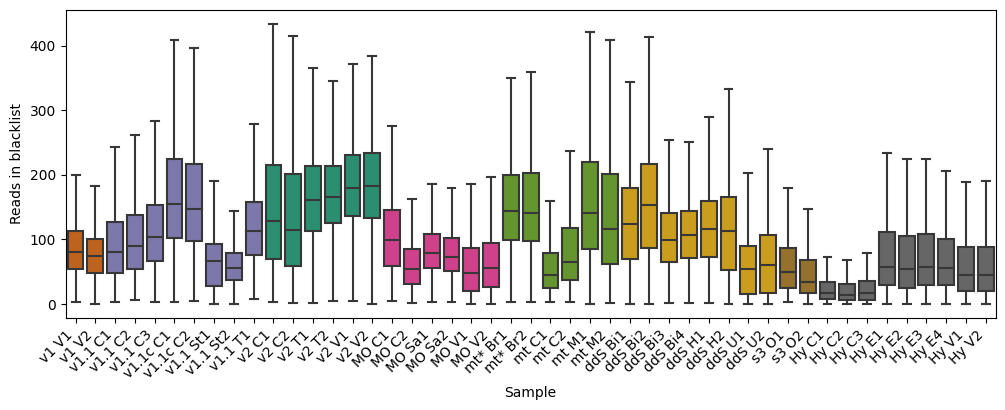

In [57]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(
    metadata_df_merged,
    y="Total_nr_frag_in_regions",
    showfliers=False,
    x="sample_id_short",
    palette=short_sample_color_palette,
    order=all_short_order,
    ax=ax,
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Sample")
plt.ylabel("Reads in blacklist")

In [59]:
import matplotlib.ticker as mtick

In [64]:
metadata_df_merged["FRIP"] = metadata_df_merged["FRIP"] * 100

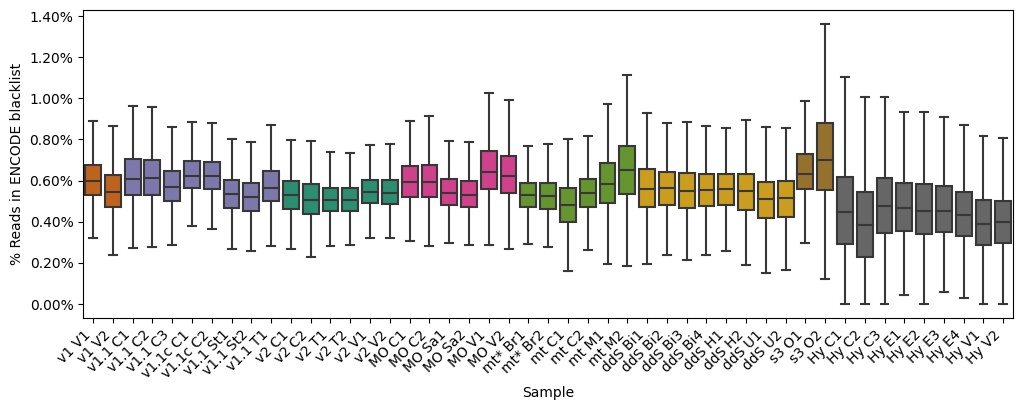

In [68]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(
    metadata_df_merged,
    y="FRIP",
    showfliers=False,
    x="sample_id_short",
    palette=short_sample_color_palette,
    order=all_short_order,
    ax=ax,
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Sample")
plt.ylabel("% Reads in ENCODE blacklist")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig("plts_final/blacklist_percentage.png", dpi=600)
plt.savefig("plts_final/blacklist_percentage.svg", dpi=600)
plt.show()

In [82]:
metadata_df_merged["tech"] = [x.split("_")[1] for x in metadata_df_merged["sample_id"]]

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'ddseq'),
  Text(1, 0, 'mtscatac'),
  Text(2, 0, '10xmultiome'),
  Text(3, 0, '10xv11'),
  Text(4, 0, '10xv2'),
  Text(5, 0, 'hydrop'),
  Text(6, 0, 's3atac'),
  Text(7, 0, '10xv1')])

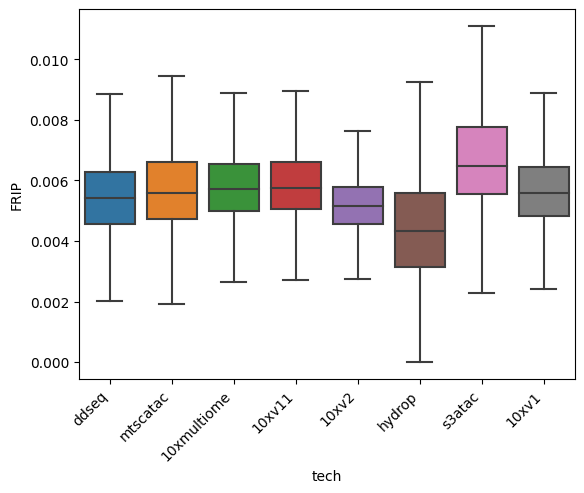

In [85]:
sns.boxplot(metadata_df_merged, y="FRIP", showfliers=False, x="tech")
plt.xticks(rotation=45, ha="right")